# Objectif :
L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Je souhaites y participer et proposer une idée d’application.

# Application proposée : 
Une application internationale nommée "Nutri'class", permettant à partir d'un Scan du Code à Barres, de classer le produit dans l'une des classes que l'algorithme de classification mettra en évidence. Par conséquent, n'importe où dans le monde, le consomateur pourra connaitre la qualité de son produit en lui indiquant à qu'elle classe de produit appartient t'il. Le consommateur pourra donc connaitre la classe et le détail des nutritions que contient le produit

## Nettoyage du jeu de données "Open Food Facts"
Le jeu de données est téléchargeable sur le site Open Food Facts : Il existe différents formats de téléchargement. J'ai choisi de faire un import au format csv. Lors du téléchargement, le jeu de données est assez important (environ 4Gb).

In [124]:
# importation des librairies nécessaires
import warnings
warnings.filterwarnings("ignore") # éviter d'afficher les alertes pythons 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno   # identifier et visualiser les données manquantes avant l'apprentissage automatique
from sklearn.impute import KNNImputer
from datetime import datetime # Manipuler des dates sous forme d'object
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [125]:
# importation du jeu de données
filename = "en.openfoodfacts.org.products.csv"
df = pd.read_csv(filename, decimal = ',', sep='\t', low_memory=False)

In [126]:
Nbr_lignes_initial = df.shape[0]
Nbr_colonnes_initial = df.shape[1]
print('Nombre de lignes initial = ',Nbr_lignes_initial)
print('Nombre de colonnes initial = ',Nbr_colonnes_initial)

Nombre de lignes initial =  2035055
Nombre de colonnes initial =  187


In [127]:
# 1- Servira à la récupération du nom de la DataFrame :
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

# 2- Calcul du nombre de lignes : 
def nb_lignes(data):
    nb_lignes = len(data)
    return nb_lignes

# 3- Calcul du nombre de colones : 
def nb_colonnes(data):
    nb_colonnes = len(data.columns)
    return nb_colonnes
    
# 4- Calcul du nombre de cellules vides : 
def nb_cell_vides(data):
    nb_cell_vides = data.isna().sum().sum()
    return nb_cell_vides

# 5- % de cellules vides par colonne : 
def pourcent_cell_vides(data):
    pd.set_option('display.max_column',70)
    pourcent_cell_vides = (data.isna().sum()/data.shape[0]).sort_values(ascending=True)
    return pourcent_cell_vides

# 6- Calcul du nombre de lignes en double: 
def Nbr_lignes_double(data):
    Nbr_lignes_double = len(data)-len(data.drop_duplicates())
    return Nbr_lignes_double

# 7- Synthèse globale des DataFrames : 
def synthese_DataFrames(data):
        print(f'--------Synthèse dataframe : {namestr(data, globals())}-------------\n')
        print(f'Nombre de colonnes : {nb_colonnes(data)}')        
        print(f'Nombre de lignes : {nb_lignes(data)}')
        print(f'Nombre de cellules vides : {nb_cell_vides(data)}')
        print(f'Nombre de lignes en doublons : {Nbr_lignes_double(data)}\n')
        print(f'Types de colonnes : {data.dtypes.value_counts()}\n')
        print(f'Pourcentage de cellules vides : {pourcent_cell_vides(data)}\n\n')
        return None
    
# 8- Liste des colonnes de la DataFrame    
def colonne_DataFrame(data):
    print(f'--------Liste des colonnes du dataframe : {namestr(data, globals())}-------------\n')
    print('Columns : {}'.format(data.columns.values))
    
# 9- Taux de remplissage
def Taux_de_remplissage_colonnes(data):
    print(f'--------Taux de remplissage : {namestr(data, globals())}-------------\n')
    taux_de_remplissage = sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap="viridis")
    taux_de_remplissage

# 10- Infos DataFrames
def info_DataFrame(data):
    data.info()
    print(f'---------------------------------------------------------------------------------\n')
    print("")

# 11- KNN-IMPUTER
def KNN(data):
    cat = list(['created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'categories_fr',
       'countries_fr', 'nutrition_grade_fr', 
       'states', 'states_tags', 'states_fr',
       'main_category_fr'])
    dataKNN = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(data.filter(regex='_100g')),
                           columns = data.filter(regex='_100g').columns)
    data = pd.concat([data[cat].reset_index(drop=True), dataKNN.reset_index(drop = True)], axis=1)
    return(data)

# 1) Analyse et traitement des colonnes 
### A) Suppression des colonnes dont on aura pas besoin

In [128]:
# suppression des colonnes dont on n'a pas besoin pour la suite de l'analyse
col_drop = ['last_modified_t','created_t','created_datetime','url', 'creator', 'quantity', 'ingredients_text', 'serving_quantity', 'serving_size', 'states',
            'main_category', 'image_url', 'image_ingredients_url', 'image_nutrition_url', 'created_datetime', 'last_modified_datetime','energy-kcal_100g'] 
df.drop(col_drop, axis=1, inplace=True)

In [129]:
rows_no_need_columns= df.shape[0]
cols_no_need_columns = df.shape[1]

print('Nombre de lignes restants = ',rows_no_need_columns)
print('Nombre de colonnes restants = ',cols_no_need_columns)

Nombre de lignes restants =  2035055
Nombre de colonnes restants =  171


### B) Traitement des valeurs manquantes

Text(0.5, 1.0, 'Missing values by feature')

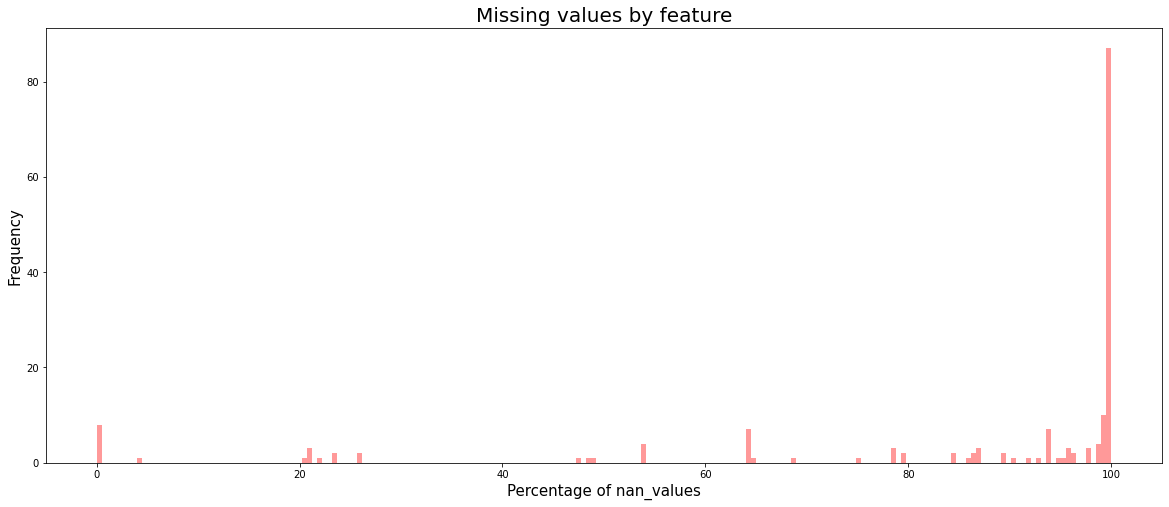

In [130]:
# densité des colonnes avec valeurs manquantes : 
nan_values = df.isnull().sum()
nan_values = nan_values / df.shape[0] *100

plt.figure(figsize=(20,8))
sns.distplot(nan_values, kde=False, bins=np.int(df.shape[0]/10000), color = "Red")
plt.xlabel("Percentage of nan_values", size = 15)
plt.ylabel("Frequency", size = 15)
plt.title("Missing values by feature", size = 20)

Comme nous pouvons le voir sur le graphique, il y a un grand nombre de colonnes avec presque aucune valeur. Nous supprimons donc les colonnes ayant plus de 85% de valeurs manquantes

In [131]:
# suppression des colonnes avec un poucentage élevé de données manquantes (>85%)
cols_of_interest = nan_values[nan_values <= 85].index
data = df[cols_of_interest]

In [132]:
rows_Prct_85 = data.shape[0]
cols_Prct_85 = data.shape[1]

print('Nombre de lignes valeurs manquantes < 85 %  = ',rows_Prct_85)
print('Nombre de colonnes valeurs manquantes < 85 %  = ',cols_Prct_85)

Nombre de lignes valeurs manquantes < 85 %  =  2035055
Nombre de colonnes valeurs manquantes < 85 %  =  42


Text(0.5, 1.0, 'Missing values by feature')

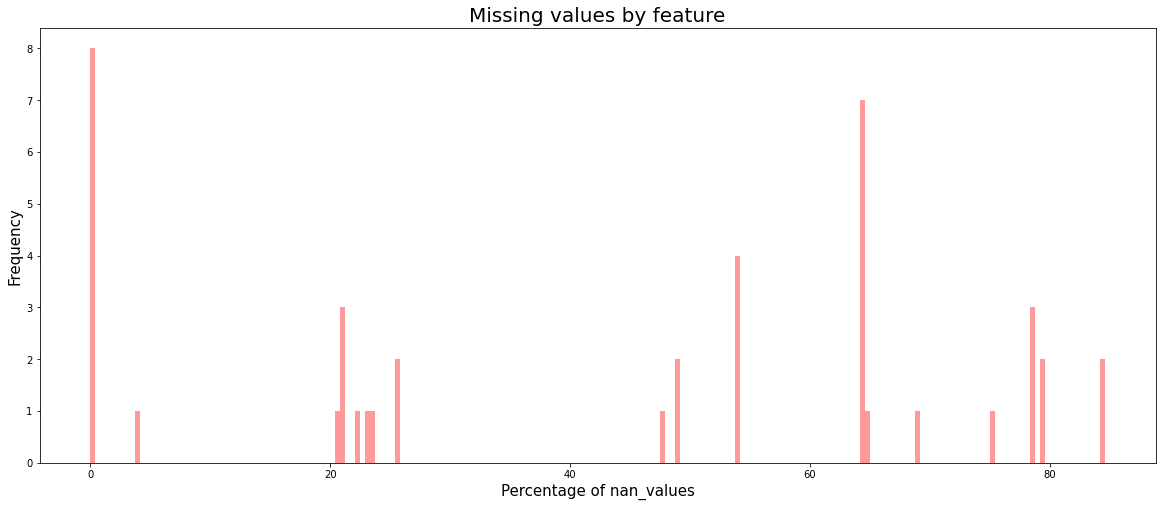

In [133]:
# densité des colonnes avec valeurs manquantes : 
nan_values = data.isnull().sum()
nan_values = nan_values / data.shape[0] *100

plt.figure(figsize=(20,8))
sns.distplot(nan_values, kde=False, bins=np.int(data.shape[0]/10000), color = "Red")
plt.xlabel("Percentage of nan_values", size = 15)
plt.ylabel("Frequency", size = 15)
plt.title("Missing values by feature", size = 20)

In [134]:
# Affichage du pourcentage de donneés manquantes
data.isnull().mean() * 100

code                                                      0.000000
product_name                                              4.078416
packaging                                                84.594618
packaging_tags                                           84.596534
brands                                                   48.767380
brands_tags                                              48.770819
categories                                               53.895792
categories_tags                                          53.896135
categories_en                                            53.896135
labels                                                   78.706521
labels_tags                                              78.707455
labels_en                                                78.707455
countries                                                 0.302989
countries_tags                                            0.303235
countries_en                                              0.30

### C) modification des types de colonnes
On constate que les colonnes "xxx_100g" sont de type Object, Nous allons les modifier en Float64 afin de procéder à l'imputation des valeurs manquantes

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035055 entries, 0 to 2035054
Data columns (total 42 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   code                                                   object 
 1   product_name                                           object 
 2   packaging                                              object 
 3   packaging_tags                                         object 
 4   brands                                                 object 
 5   brands_tags                                            object 
 6   categories                                             object 
 7   categories_tags                                        object 
 8   categories_en                                          object 
 9   labels                                                 object 
 10  labels_tags                                            object 
 11

In [136]:
# modification des types de colonnes "xxx_100g" en float pour une meilleur imputation
num_col = ["energy_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g", "proteins_100g", "fiber_100g", "salt_100g", "sodium_100g", "sugars_100g", "fruits-vegetables-nuts-estimate-from-ingredients_100g"]
for col in num_col:
    data[col] = pd.to_numeric(data[col])

### On voit que les colonnes  "xxx_100g" sont maintenant de type Float64

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035055 entries, 0 to 2035054
Data columns (total 42 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   code                                                   object 
 1   product_name                                           object 
 2   packaging                                              object 
 3   packaging_tags                                         object 
 4   brands                                                 object 
 5   brands_tags                                            object 
 6   categories                                             object 
 7   categories_tags                                        object 
 8   categories_en                                          object 
 9   labels                                                 object 
 10  labels_tags                                            object 
 11

### D) Visualisation des colonnes 

<AxesSubplot:>

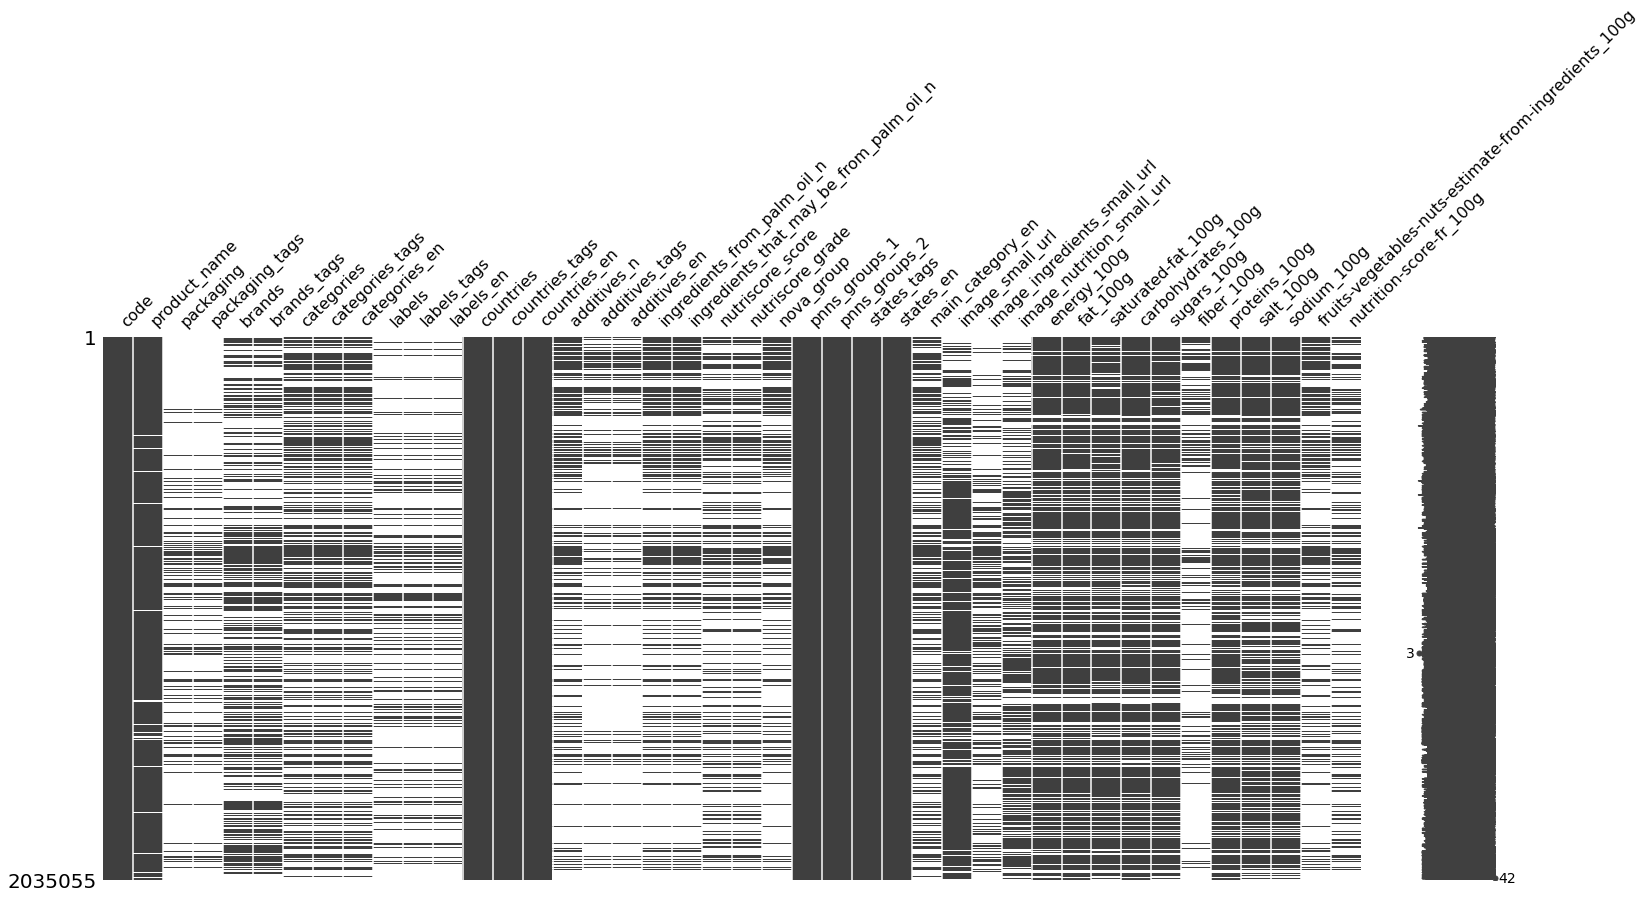

In [138]:
msno.matrix(data)

<AxesSubplot:>

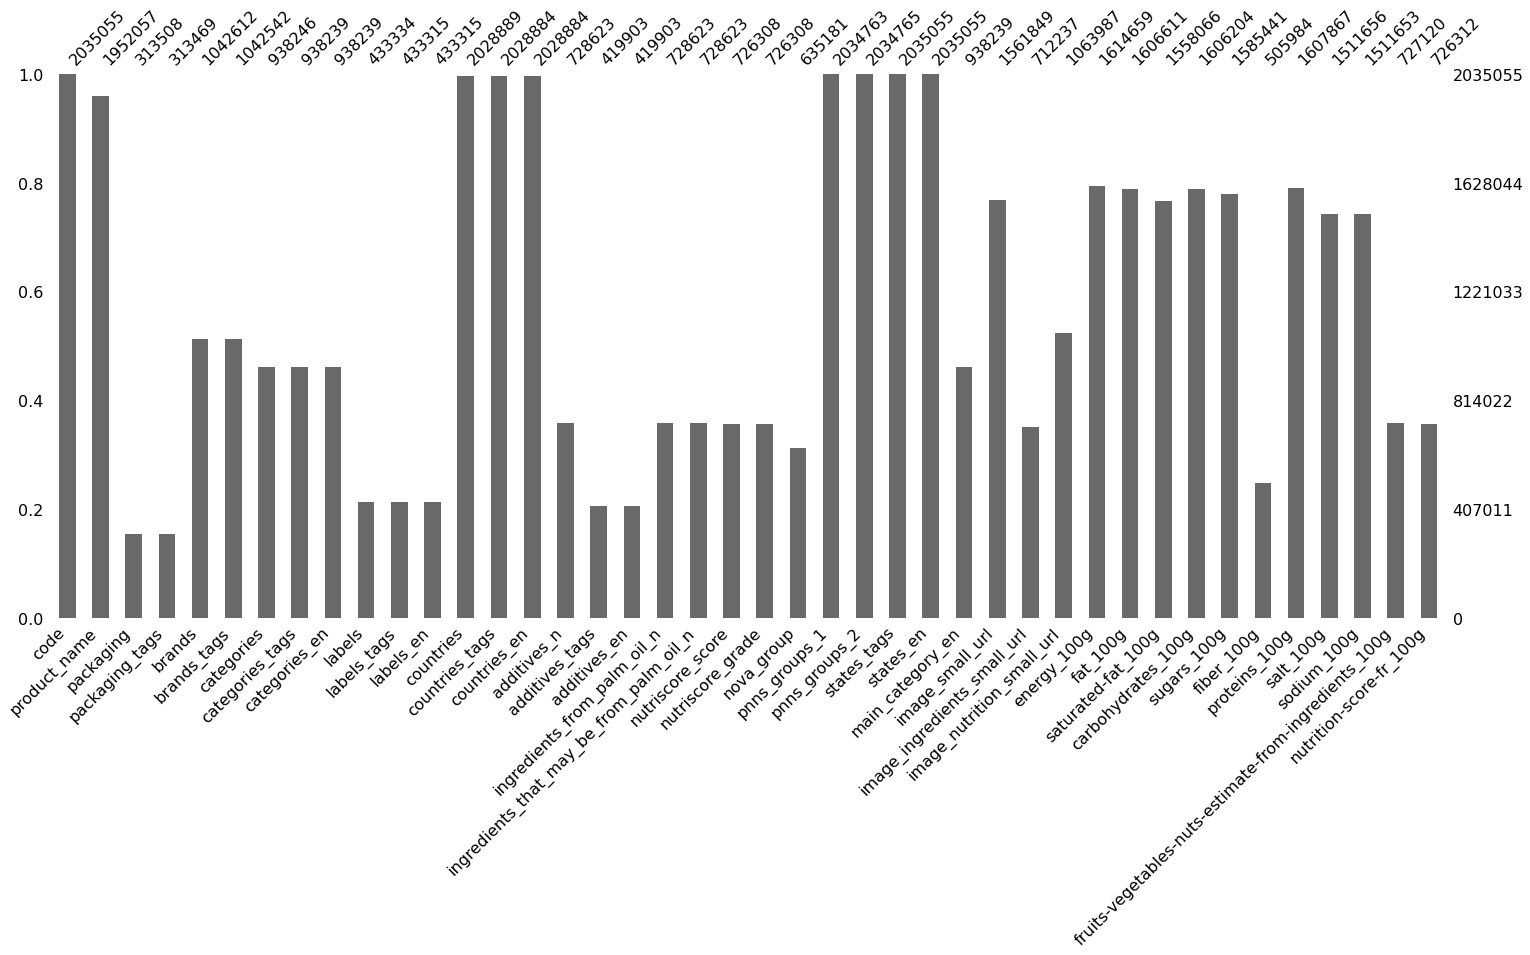

In [139]:
%matplotlib inline
msno.bar(data)

### E) Traitement des redondances dans les colonnes
des colonnes dont les noms sont différents mais donnent la même information (les colonnes _en ou _tags par exemple)

In [140]:
# Suppression des colonnes redondantes avec sufixe + les urls des images des produits
drop_cols = ["brands_tags", "categories_tags", "categories_en", "countries_tags", "countries_en", "states_tags", "states_en", "salt_100g",
             "main_category_en", "image_small_url", "image_ingredients_small_url", "image_nutrition_small_url", "nutrition-score-fr_100g"]
data.drop(drop_cols, axis=1, inplace=True)

In [141]:
rows_redundant_columns= data.shape[0]
cols_redundant_columns = data.shape[1]
print('Nombre de lignes restants = ',rows_redundant_columns)
print('Nombre de colonnes restants = ',cols_redundant_columns)

Nombre de lignes restants =  2035055
Nombre de colonnes restants =  29


# 2) Analyse des traitement des lignes 

### A)  Pour une quantité de 100g, la valeur d'un nutriement ou d'un aliment est forcément entre [0,100] , alors filtrons les valeurs inférieures à 0 et les valeurs suppérieurs à 100 dans les colonnes "xxx_100g" 

In [142]:
# Suppression des outliers :   
cols = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', "fiber_100g", "proteins_100g", "sodium_100g", "fruits-vegetables-nuts-estimate-from-ingredients_100g"]

for col in cols : 
    ind = data.loc[(data[col] < 0) | (data[col] > 100)].index.to_list()
    data.drop(index=ind, inplace=True)

In [143]:
rows_outliers= data.shape[0]
cols_outliers = data.shape[1]

print('Nombre de lignes restants = ',rows_outliers)
print('Nombre de colonnes restants = ',cols_outliers)

Nombre de lignes restants =  2032655
Nombre de colonnes restants =  29


In [144]:
data.columns

Index(['code', 'product_name', 'packaging', 'packaging_tags', 'brands',
       'categories', 'labels', 'labels_tags', 'labels_en', 'countries',
       'additives_n', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g'],
      dtype='object')

In [145]:
data.head()

,code,product_name,packaging,packaging_tags,brands,categories,labels,labels_tags,labels_en,countries,...,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,NaN,NaN,endives,NaN,NaN,NaN,NaN,en:france,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,...,unknown,NaN,1.4,0.90,9.8,9.8,NaN,2.7,0.04,0.0
2,0000000000017,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,...,unknown,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,0.56,NaN
3,0000000000031,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Espagne,...,unknown,685.8,1.9,1.00,NaN,NaN,NaN,15.3,0.44,NaN


### B) Traitement des informations redondantes

In [146]:
# affichage des entrées multiples dans notre dataset
data.duplicated().sum()

5

In [147]:
# Suppression des doublons : 
data.drop_duplicates(inplace=True)

In [148]:
rows_duplicates= data.shape[0]
cols_duplicates = data.shape[1]

print('Nombre de lignes restants = ',rows_duplicates)
print('Nombre de colonnes restants = ',cols_duplicates)

Nombre de lignes restants =  2032650
Nombre de colonnes restants =  29


<AxesSubplot:>

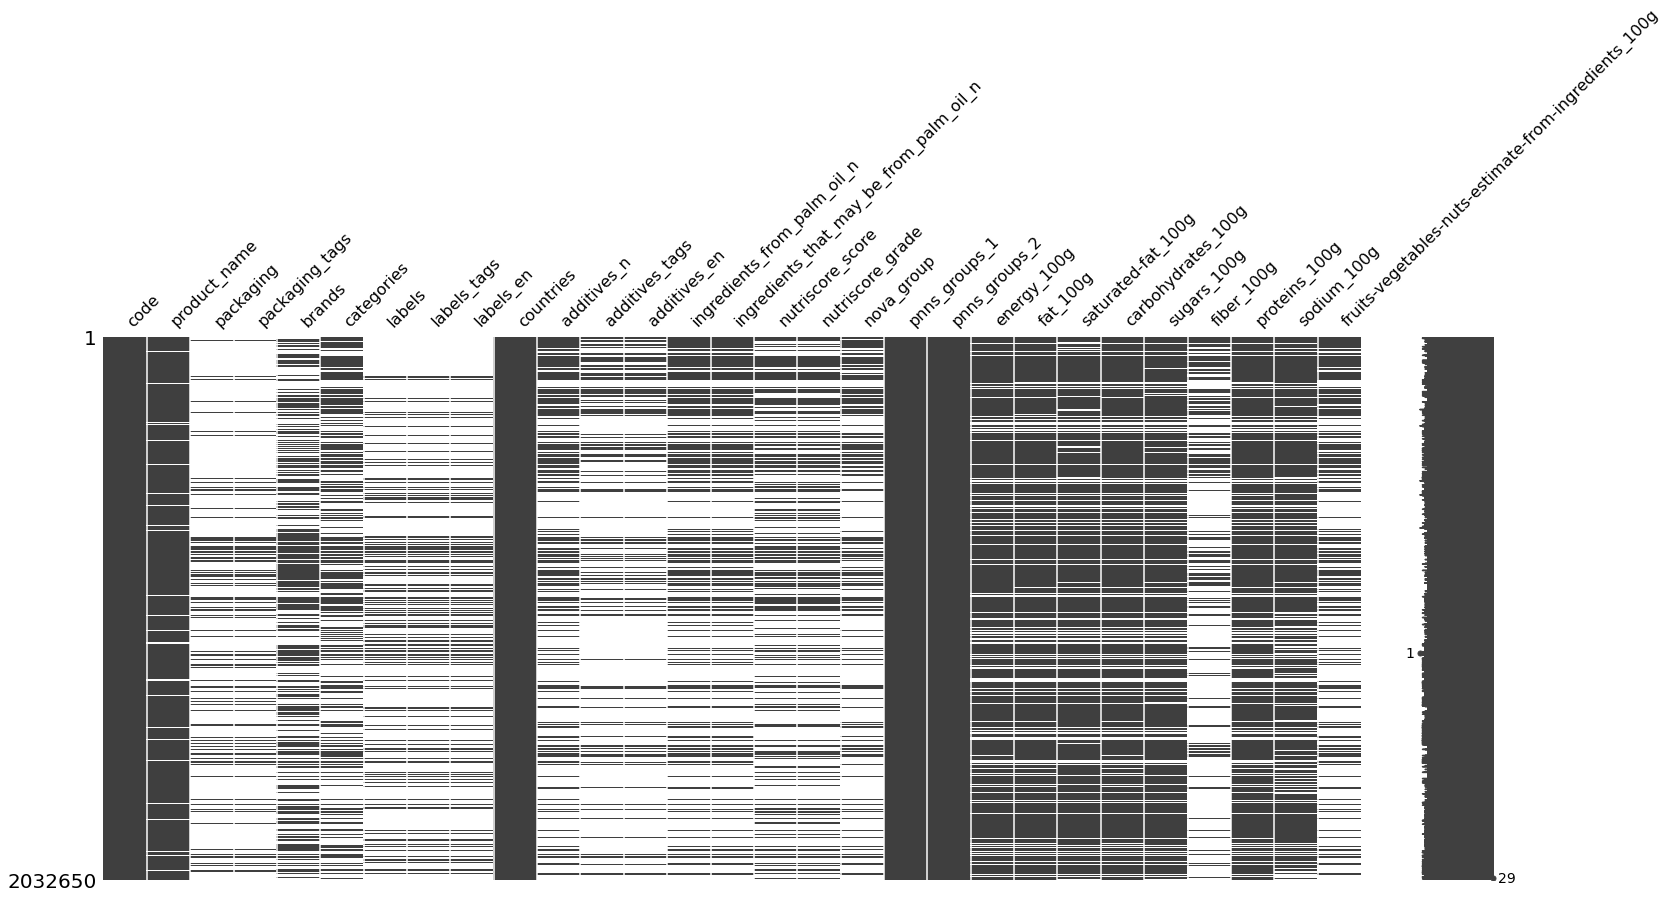

In [149]:
msno.matrix(data)

<AxesSubplot:>

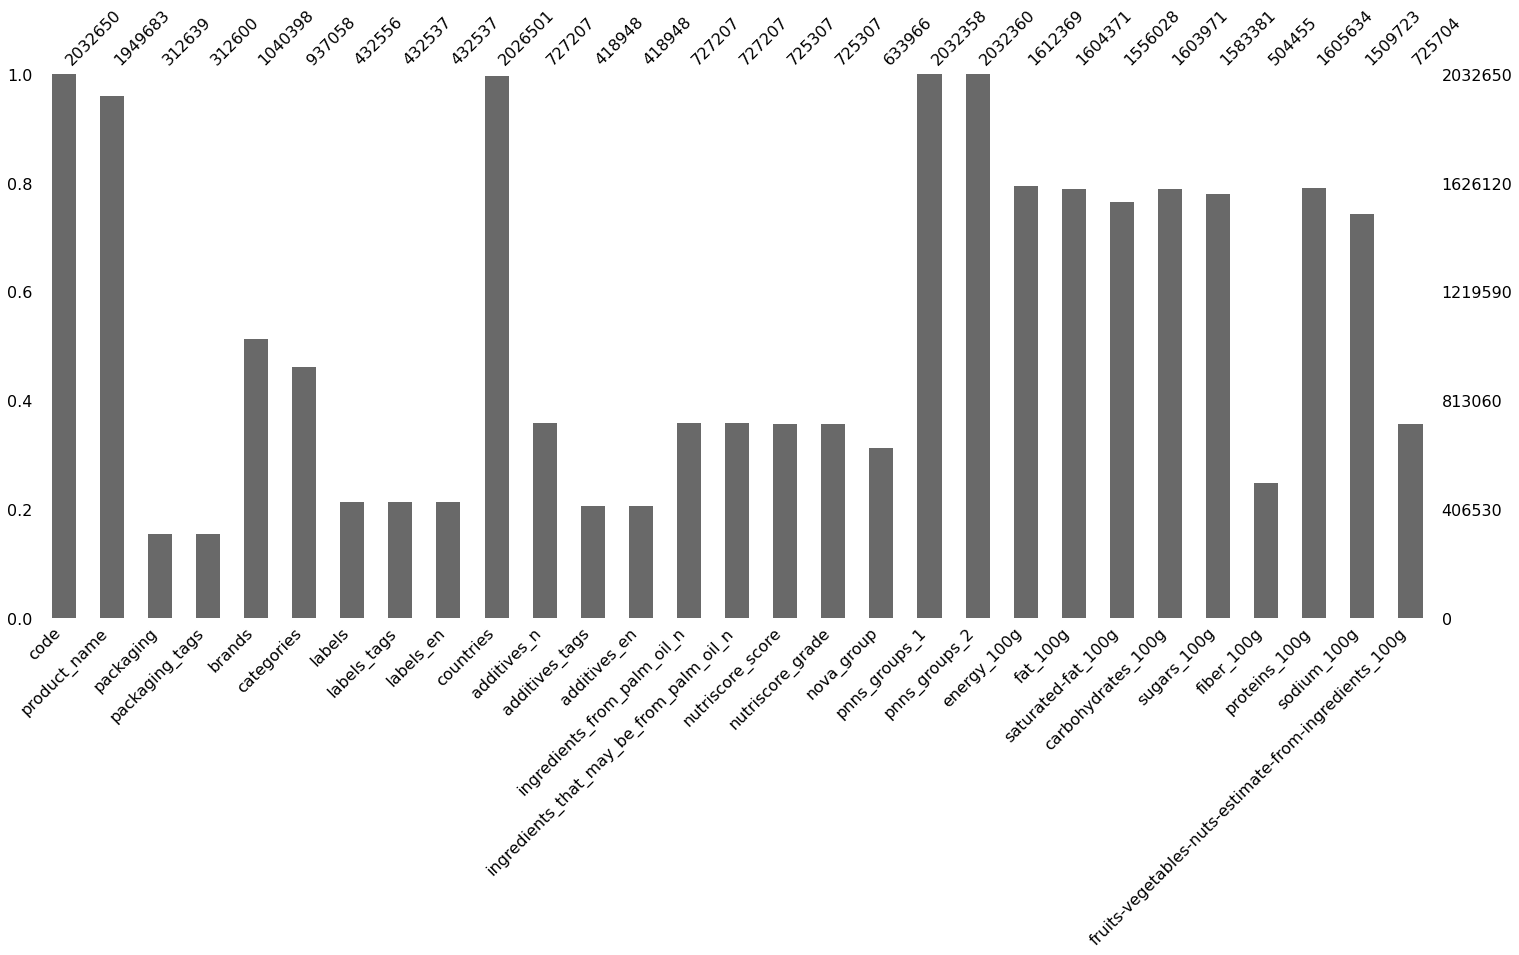

In [150]:
msno.bar(data)

In [151]:
# Suppression des produits avec valeur energétique négative et suppérieure à 3768.12 KJ
column = ["energy_100g"]
for col in column : 
    ind = data.loc[(data[col] < 0) | (data[col] > 3768.12)].index.to_list()
    data.drop(index=ind, inplace=True)

In [152]:
rows_drop_energy_higher_900_lower_0= data.shape[0]
cols_drop_energy_higher_900_lower_0 = data.shape[1]

print('Nombre de lignes restants = ',rows_drop_energy_higher_900_lower_0)
print('Nombre de colonnes restants = ',cols_drop_energy_higher_900_lower_0)

Nombre de lignes restants =  2026544
Nombre de colonnes restants =  29


In [153]:
data.isna().sum()

code                                                           0
product_name                                               82920
packaging                                                1714399
packaging_tags                                           1714438
brands                                                    988511
categories                                               1091020
labels                                                   1594884
labels_tags                                              1594903
labels_en                                                1594903
countries                                                   6129
additives_n                                              1300306
additives_tags                                           1608001
additives_en                                             1608001
ingredients_from_palm_oil_n                              1300306
ingredients_that_may_be_from_palm_oil_n                  1300306
nutriscore_score         

# KNN-IMPUTER

Dans notre cas, les NaN ne peuvent pas être directement traités par le KNN-imputer. Par exemple : on ne peut pas comparer les vitamines manquantes dans un produit alors que ce produit n'en contient peut être pas. 
Les valeurs manquantes de chaque échantillon sont imputées à l’aide de la valeur moyenne des voisins les plus proches trouvés dans l’ensemble d’entraînement....... si par exemple, éstimer le sucre d'un produit par rapport a ces knn, alors que ce produit ne contient pas de sucre, on se retrouve avec un DF mathématiquement propre mais érroné. 

Nous avons donc décider de remplacer les valeurs manquantes d'un produit avec la médiane de la catégorie à laquelle appartient le produit. 

# Imputation par la médiane par catégorie : 

In [154]:
# Cette imputation est réaliser uniquement pour les valeurs numériques

for cols in data.columns:
    if data[cols].dtypes == "float64":
        data[cols].fillna(data.groupby('pnns_groups_2')[cols].transform('median'), inplace=True)

#### On vérifie que l'imputation a bien eu lieu : Les colonne concernées sont passées à 100% en taux de remplissage 

<AxesSubplot:>

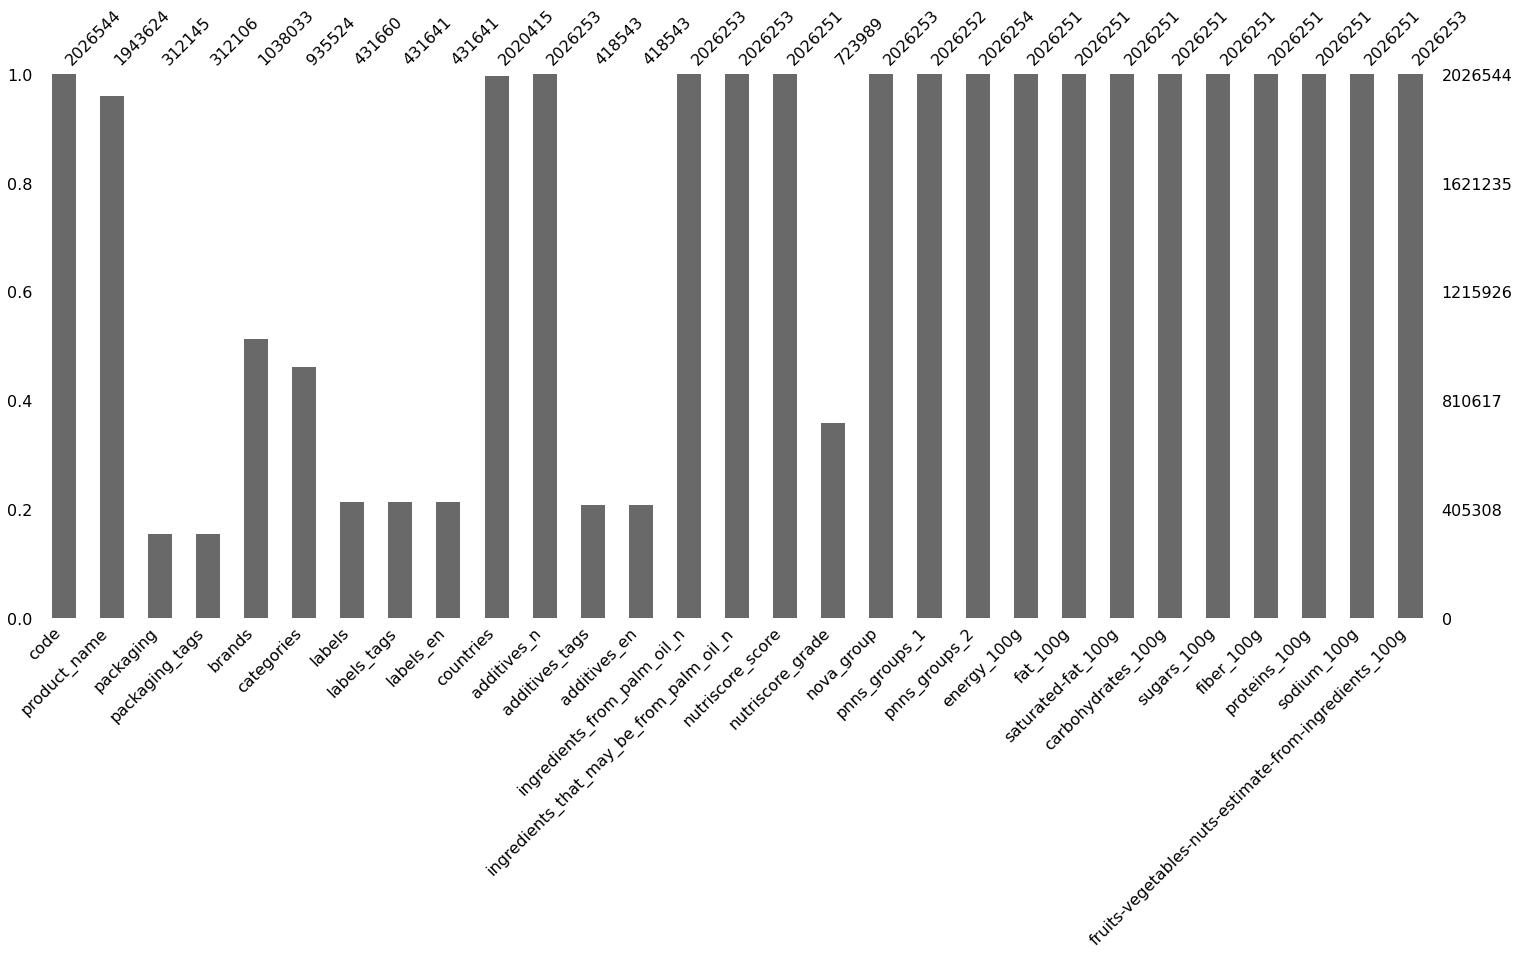

In [155]:
msno.bar(data)

In [156]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
count,2.026253e+06,2.026253e+06,2.026253e+06,2.026251e+06,2.026253e+06,2.026251e+06,2.026251e+06,2.026251e+06,2.026251e+06,2.026251e+06,2.026251e+06,2.026251e+06,2.026251e+06,2.026253e+06
mean,1.356745e+00,7.242926e-03,2.710668e-02,9.498655e+00,3.727279e+00,1.108623e+03,1.227926e+01,4.294813e+00,2.586433e+01,1.124328e+01,2.183255e+00,8.127601e+00,4.666722e-01,3.526366e+00
std,1.849606e+00,8.594128e-02,1.898577e-01,5.628236e+00,7.015746e-01,7.301980e+02,1.621298e+01,7.007158e+00,2.569705e+01,1.784634e+01,2.704444e+00,9.018472e+00,1.802803e+00,1.447992e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,5.100000e+02,1.300000e+00,2.000000e-01,4.705882e+00,9.000000e-01,1.200000e+00,2.000000e+00,4.400000e-02,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,1.088000e+03,7.000000e+00,1.700000e+00,1.740000e+01,3.570000e+00,2.200000e+00,6.100000e+00,2.320000e-01,0.000000e+00
75%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,1.552000e+03,1.700000e+01,5.000000e+00,4.640000e+01,1.180000e+01,2.200000e+00,1.030000e+01,4.400000e-01,0.000000e+00
max,4.900000e+01,3.000000e+00,6.000000e+00,4.000000e+01,4.000000e+00,3.768120e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02


In [157]:
data.head()

,code,product_name,packaging,packaging_tags,brands,categories,labels,labels_tags,labels_en,countries,...,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,NaN,NaN,endives,NaN,NaN,NaN,NaN,en:france,...,unknown,1088.0,7.0,1.70,17.4,3.57,2.2,6.1,0.232,0.0
1,00000000000003429145,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,...,unknown,1088.0,1.4,0.90,9.8,9.80,2.2,2.7,0.040,0.0
2,0000000000017,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,...,unknown,1569.0,7.0,3.08,70.1,15.00,2.2,7.8,0.560,0.0
3,0000000000031,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,...,unknown,1088.0,7.0,1.70,17.4,3.57,2.2,6.1,0.232,0.0
4,000000000003327986,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Espagne,...,unknown,685.8,1.9,1.00,17.4,3.57,2.2,15.3,0.440,0.0


Remarques : 
----------------
1/ On constate certains produits sans nom "product_name"

2/ On constate qu'un % élevé de produits n'ont pas de valeurs concernant leur quote-part dans 100gr de produit. Pour imputer      les valeurs manquantes pour chaque produit, l'idée est de regrouper par catégorie de produit (colonne "pnns_groups_2") et 
   remplacer les valeurs des produits non renseignés par la moyenne de son groupe. 

Actions: 
----------
1/ Supprimons des produits sans nom

2/ Regroupons d'abord par groupe de produit et voyons ce qu'on a comme groupes de produits différents (sont'ils correctement renseignés ?...)

In [159]:
# Suppression des produits sans nom
data.dropna(subset=['product_name'], inplace=True) 

In [160]:
rows_drop_no_name_products= data.shape[0]
cols_drop_no_name_products = data.shape[1]

print('Nombre de lignes restants = ',rows_drop_no_name_products)
print('Nombre de colonnes restants = ',cols_drop_no_name_products)

Nombre de lignes restants =  1943624
Nombre de colonnes restants =  29


In [161]:
data.tail(50)

,code,product_name,packaging,packaging_tags,brands,categories,labels,labels_tags,labels_en,countries,...,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
2035005,9999926741689,Vitaquell extra,NaN,NaN,NaN,NaN,"Organic, en:de-oko-013","en:organic,en:eu-organic,en:de-oko-013","Organic,EU Organic,DE-ÖKO-013",en:CH,...,unknown,1088.0,7.00,1.70,17.40,3.570,2.2,6.10,0.232,0.0
2035006,99999300000,Rooibos nature Bio,NaN,NaN,Nature Bio,NaN,Bio,en:organic,Organic,en:FR,...,unknown,1088.0,7.00,1.70,17.40,3.570,2.2,6.10,0.232,0.0
2035007,9999933090183,Pasta lassar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chile,...,unknown,1088.0,7.00,1.70,17.40,3.570,2.2,6.10,0.232,0.0
2035008,9999990000514,Miel de Garriguella,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,...,unknown,1088.0,7.00,1.70,17.40,3.570,2.2,6.10,0.232,0.0
2035009,9999990001610,Son de blé Bio,NaN,NaN,NaN,NaN,Bio,en:organic,Organic,en:fr,...,unknown,1088.0,7.00,1.70,17.40,3.570,2.2,6.10,0.232,0.0
2035010,9999990002785,Bière fermière miel de forêt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,...,unknown,1088.0,7.00,1.70,17.40,3.570,2.2,6.10,0.232,0.0
2035011,9999990003508,Confiture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:fr,...,unknown,967.0,0.14,0.02,55.53,55.520,2.2,0.34,0.000,0.0
2035012,9999990004284,Rillettes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:fr,...,unknown,1088.0,7.00,1.70,17.40,3.570,2.2,6.10,0.000,0.0
2035013,9999990004529,Miel d'acacia ruchers de badon,NaN,NaN,NaN,"Produits à tartiner, Petit-déjeuners, Produits...",NaN,NaN,NaN,en:fr,...,Sweets,1502.0,0.50,0.18,63.64,53.000,1.0,0.82,0.020,0.0
2035014,9999990005052,Confiture de pêche,NaN,NaN,NaN,fr:Confiture de pêche,NaN,NaN,NaN,en:fr,...,Sweets,1502.0,0.50,0.18,63.64,53.000,1.0,0.82,0.020,0.0


In [162]:
# Regroupement par groupe de produits
data_by_product=data.groupby(["pnns_groups_2"]).mean()
data_by_product

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
pnns_groups_2,,,,,,,,,,,,,,
Alcoholic beverages,0.183618,0.000000,0.001084,6.006674,3.092237,197.888688,0.202559,0.076414,5.027401,1.393929,0.027682,0.350482,0.058311,1.072980
Appetizers,1.553018,0.026045,0.091537,12.273264,3.757839,1909.162030,23.446062,4.261888,51.918709,3.488210,4.037483,7.727843,0.627995,1.993483
Artificially sweetened beverages,5.243818,0.001043,0.040480,4.853625,3.990923,259.821661,0.921887,0.661237,9.172488,4.900616,0.339542,2.060494,0.157934,1.343755
Biscuits and cakes,4.222269,0.060315,0.136416,17.614508,3.908715,1765.357996,18.250084,7.816944,58.508794,28.855128,2.683715,6.176455,0.308287,2.373501
Bread,2.186005,0.016208,0.118208,4.017516,3.802405,1246.812176,5.651631,1.076767,51.428366,4.554146,3.975172,9.357850,0.521205,0.380901
Breakfast cereals,0.523044,0.043764,0.039822,5.377704,3.604205,1628.358611,8.505994,2.261632,65.478307,15.954515,7.390875,9.632266,0.225008,3.019282
Cereals,0.658601,0.012268,0.019067,1.594018,2.608755,1467.890962,6.463462,1.632773,62.228933,6.169568,4.534992,10.015581,0.199320,0.723985
Cheese,0.620261,0.000257,0.009976,14.120680,3.233979,1379.317746,26.470372,17.120168,2.487282,1.136539,0.074169,20.823123,0.637885,0.150154
Chocolate products,1.085435,0.018364,0.029809,22.994677,3.878302,2275.907847,36.116440,20.959891,46.179405,40.034096,5.209751,7.314027,0.089884,2.138287


Nous constatons que les patisseries "pastries" sont vides 
Supprimons ce  groupe de produits

Nous constatons également que les pays sont mal renseignés (dû à des saisie manuelles), nous devons corriger cela afin   

In [163]:
# Suppression des groupes de produits redondants / vides
column = ["pnns_groups_2"]
for col in column : 
    ind = data.loc[(data[col] == "pastries")].index.to_list()
    data.drop(index=ind, inplace=True)

In [164]:
rows_drop_pastries_group= data.shape[0]
cols_drop_pastries_group = data.shape[1]
print('Nombre de lignes restants = ',rows_drop_pastries_group)
print('Nombre de colonnes restants = ',cols_drop_pastries_group)

Nombre de lignes restants =  1943622
Nombre de colonnes restants =  29


In [167]:
# Cette imputation est réalisée uniquement pour les valeurs numériques
for cols in data.columns:
    if data[cols].dtypes == "float64":
        data[cols].fillna(data.groupby('pnns_groups_2')[cols].transform('median'), inplace=True)

<AxesSubplot:>

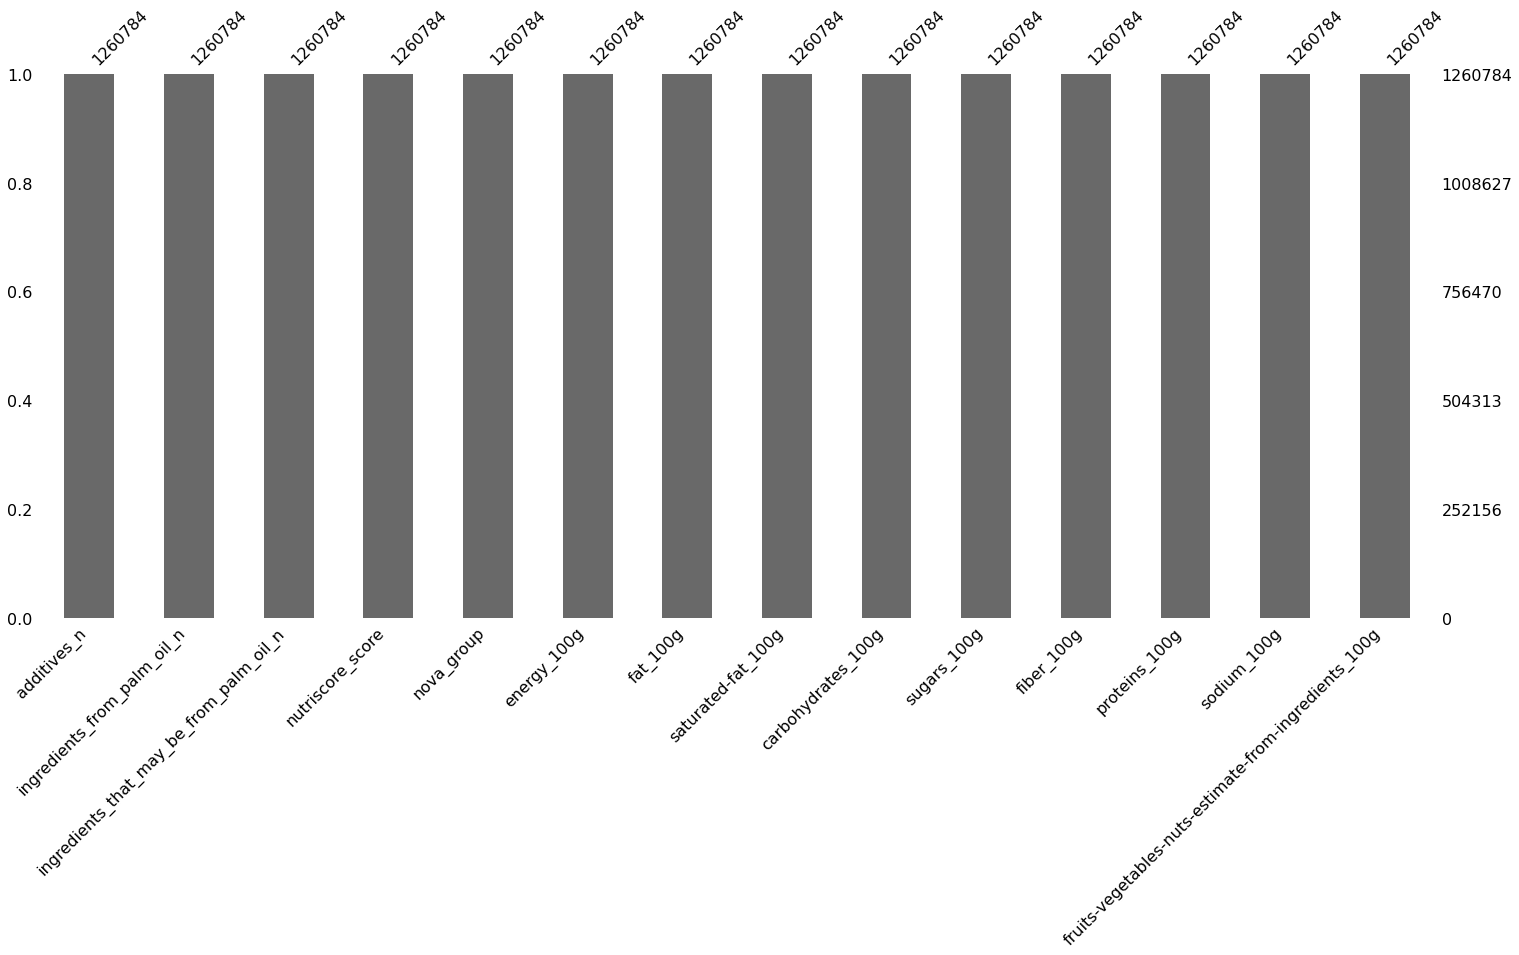

In [171]:
msno.bar(data_by_product)

<AxesSubplot:>

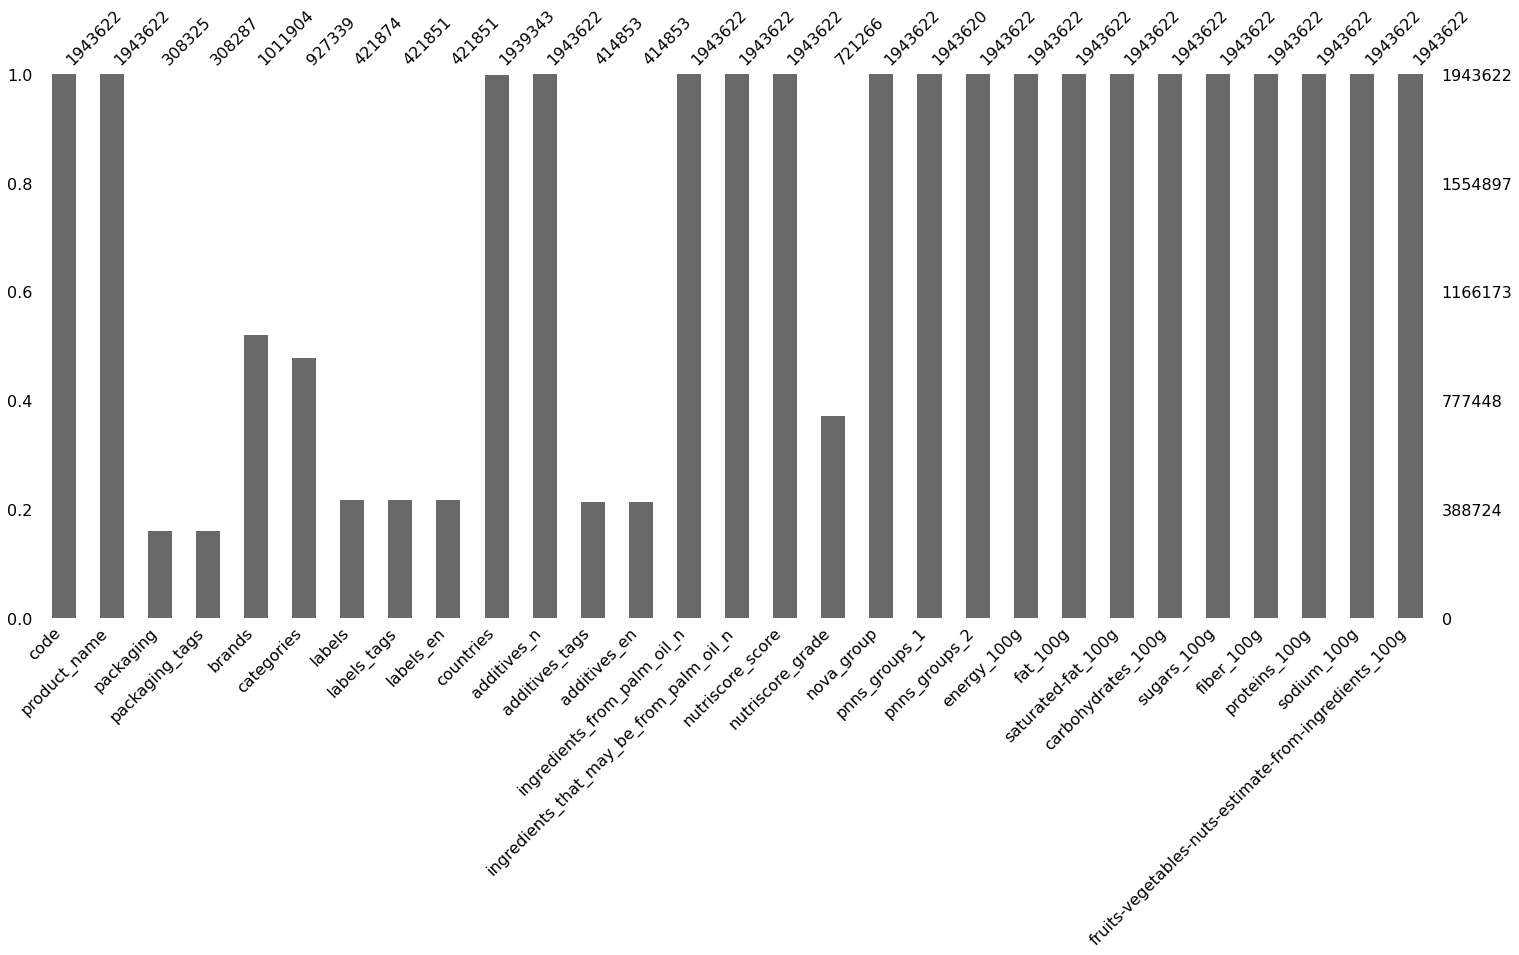

In [172]:
msno.bar(data)

## C) Traitement des chaines de caractères :  

Remplaçons les valeurs manquantes des catégories par la valeur "unknown" au lieu de "NaN". 
Concernant les pays, on remplace les pays manquants par la valeur "other". 
Ces modifications empêcheront la suspension des lignes lors de l'utilisation de la fonction dropna.

In [173]:
data["categories"].fillna("unknown", inplace=True)

In [174]:
data["countries"].fillna("other", inplace=True)

In [175]:
countries_translate ={
    "France" : "France",
    "Francia" : "France",
    "Frankreich" : "France",
    "fr" : "France",
    "Germany" : "Allemagne",
    "Deutschland" : "Allemagne",
    "de" : "Allemagne",
    "España" : "Espagne",
    "Spain" : "Espagne",
    "en:es" : "Espagne",
    "United States" : "Etats-Unis",
    "USA" : "Etats-Unis",
    "Us" : "Etats-Unis",
    "United Kingdom" : "Royaume-Uni",
    "united-kingdom" : "Royaume_Uni",
    "England" : "Angleterre",
    "Scotland" : "Ecosse",
    "Ireland" : "Irlande",
    "Wales" : "Pays de Galles",
    "Polska" : "Pologne",
    "México" : "Mexique",
    "mexico" : "Mexique",
    "Belgium" : "Belgique",
    "be" : "Belgique",
    "Netherlands" : "Pays-Bas",
    "Magyarország" : "Hongrie",
    "Hungary" : "Hongrie",
    "new caledonia" : "Nouvelle-Calédonie",
    "Switzerland" : "Suisse",
    "Sverige" : "Suède",
    "Sweden" : "Suède",
    "Norway" : "Norvège",
    "Norge" : "Norvège",
    "Suomi" : "Finlande",
    "Finland" : "Finlande",
    "Bulgaria" : "Bulgarie",
    "България" : "Bulgarie",
    "Bǎlgarija" : "Bulgarie",
    "Россия" : "Russie",
    "Russia" : "Russie",
    "Italy" : "Italie",
    "Italia" : "Italie",
    "Thailand" : "Thaïlande",
    "Canada" : "Canada",
    "Brazil" : "Brésil",
    "Réunion" : "France",
    "Républik kongo" : "République du Congo",
    "Republik kongo" : "République du Congo",
    "Congo" : "République du Congo",
    "Mo" : "Macao",
    "malaysia" : "Malaisie",
    "my" : "Malaisie",
    "singapore" : "Singapour",
    "Jemen" : "Yémen",
    "mali" : "Mali",
    "Burkina faso" : "Burkina Faso",
    "En:sr" : "Singapour",
    "En:ye" : "Yémen",
    "Nueva zelanda" : "Nouvelle-Zélande",
    "New Zealand" : "Nouvelle-Zélande",
    "Taiwan" : "Taiwan",
    "Sn" : "Sénégal",
    "Senegal" : "Sénégal",
    "Grecia" : "Grèce",
    "Ελλάδα " : "Grèce",
    "Nueva caledonia" : "Nouvelle Calédonie",
    "lu" : "Luxembourg",
    "united-states" : "Etats-Unis",
    "En:it" : "Italie",
    "En:ivory coast" : "Cote d'Ivoire",
    "Schweiz" : "Suisse",
    "Slovenia" : "Slovénie",
    "ફ્રાન્સ" : "France",
    "En:ae" : "Emirats arabes unis",
    "united arab emirates" : "Emirats arabes unis",
    "dominican republic" : "République dominicaine",
    "En:re" : "France",
    "En:gb" : "Royaume-Uni",
    "Great Britain" : "Royaume-Uni",
    "En:ch" : "Suisse",
    "En:ca" : "Canada",
    "saudi arabi" : "Arabie Saoudite",
    "Romania" : "Roumanie",
    "En:pl" : "Pologne",
    "Chile" : "Chili",
    "En:el salvador" : "Salvador",
    "En:luxembourg" : "Luxembourg",
    "luxemburg" : "Luxembourg",
    "Stati uniti d'america" : "Etats-Unis",
    "En:ie" : "Irlande",
    "En:ad" : "Andorre",
    "royaume-uni" : "Royaume-Uni",
    "sv" : "Salvador",
    "En:jersey" : "Jersey",
    "jersey" : "Jersey",
    "En:gi" : "Gibraltar",
    "República dominicana" : "République dominicaine",
    "En:hk" : "Hong Kong",
    "En:mu" : "Ile Maurice",
    "En:uk" : "Royaume-Uni",
    "En:cr" : "Costa Rica",
    "En:portugal" : "Portugal",
    "Vereinigte staaten von amerika" : "Etats-Unis",
    "En: kuweit" : "Koweit",
    "En:hn" : "Honduras",
    "En:au" : "Australie",
    "En:at" : "Autriche",
    "En:pr" : "Porto Rico",
    "En:mc" : "Macao",
    "Hrvatska" : "Croatie",
    "En:egypt" : "Egypte",
    "Égypte" : "Egypte",
    "En:mx" : "Mexique",
    "En:pakistan" : "Pakistan",
    "En:pm" : "France",
    "En:pa" : "Panama",
    "En:ma" : "Maroc",
    "澳大利亚" : "Australie",
    "En:do" : "République dominicaine",
    "Estados unidos" : "Etats-Unis",
    "السعودية" : "Arabie Saoudite",
    "Saudi-arabien" : "Arabie Saoudite",
    "العراق" : "Iraq",
    "En:sa" : "Arabie Saoudite",
    "En:om" : "Oman",
    "gp" : "France",
    "pf" : "France",
    "El-salvador" : "Salvador",
    "En:indonesia" : "Indonésie",
    "الكويت" : "Koweit",
    "colombia" : "Colombie",
    "Martinique" : "France",
    "Guadeloupe" : "France",
    "Guyane" : "France",
    "En:czechia" : "République Tchèque",
    "En:puerto rico" : "Puerto Rico",
    "美国" : "Etats-Unis",
    "En:sg" : "Singapour",
    "Reino unido" : "Royaume-Uni",
    "En:lb" : "Liban",
    "En:costa rica" : "Costa Rica",
    "En:tt" : "Trinité-Et-Tobago",
    "En:ve" : "Venuezela",
    "En:israel" : "Israël",
    "israel" : "Israel",
    "Saudi-arabia" : "Arabie Saoudite",
    "Panamá" : "Panama",
    "En:isle of man" : "Royaume-Uni",
    "En:nc" : "Nouvelle-Calédonie",
    "En:bs" : "Bahamas",
    "En:nl" : "Pays-Bas",
    "En:jm" : "Jamaïque",
    "Jamaique" : "Jamaïque",
    "Jamaica" : "Jamaïque",
    "ประเทศฝรั่งเศส" : "France",
    "En:iraq":"Iraq",
    "En:ke" : "Kenya",
    "Jordan" : "Jordanie",
    "Poland" : "Pologne",
    "En:honduras" : "Honduras",
    "لولايات المتحدة" : "Etats-Unis",
    "En:hong kong": "Hong Kong",
    "Prancūzija" : "France",
    "Vereinigtes königreich" : "Royaume-Uni",
    "En:guinea" : "Guinée",
    "En:algeria" : "Algérie",
    "法国" : "France",
    "香港" : "Hong Kong",
    "Hong kong" : "Hong Kong",
    "Costa-rica" : "Costa Rica",
    "En:nz" : "Nouvelle-Zélande",
    "En:ghana" : "Ghana",
    "En:yt" : "France",
    "Wielka brytania" : "Royaume-Uni",
    "Maurice" : "Ile Maurice",
    "En:sc" : "Seychelles",
    "En:ecuador" : "Equateur",
    "En:cl" : "Chili",
    "中华人民共和国" : "Chine",
    "ประเทศไทย" : "Thaïlande",
    "En:pt" : "Portugal",
    "En:vi" : "Etats-Unis",
    "En:cm" : "Cameroun",
    "En:mk" : "Macédoine",
    "En:qa": "Qatar",
    "En:qatar" : "Qatar",
    "En:venezuela" : "Venézuela",
    "China" : "Chine",
    "en:greece" : "Grèce",
    "en:th" : "Thaïlande",
    "en:vietnam" : "Vietnam",
    "Suisse" : "Suisse",
    "En:gt" : "Guatemala",
    "En:mq" : "France",
    "Serbia" : "Serbie",
    "En:jp" : "Japon",
    "En:in" : "Inde",
    "America" : "Etats-Unis",
    "En:niger" : "Niger",
    "Panama" : "Panama",
    "En:japan" : "Japon",
    "En:barbados" : "Barbades",
    "En:lybia" : "Lybie",
    "En:poland" : "Pologne",
    "En:je" : "Jersey",
    "En:co" : "Colombie",
    "Riunione" : "France",
    "Bahreïn" : "Bahreïn",
    "En:mm" : "Birmanie",
    "En:haiti" : "Haïti",
    "En:pk" : "Pakistan",
    "En:afghanistan" : "Afghanistan",
    "En:gh" : "Ghana",
    "En:suriname" : "Suriname",
    "Γαλλία" : "France",
    "Trinidad and Tobago" : "Trinité-Et-Tobago",
    "En:south korea" : "Corée du Sud",
    "En:jo" : "Jordanie",
    "En:hr" : "Croatie", 
    "En:sm" : "Saint-Marin",
    "San Marin" : "Saint-Marin",
    "الإمارات العربية المتحدة" : "Emirats arabes unis",
    "En:lybia" : "Lybie",
    "India" : "Inde",
    "En:guyana" : "Guyana",
    "En:antigua and barbuda" : "Antigua-et-Barbuda",
    "Espagne" : "Espagne",
    "En:py" : "Paraguay",
    "Bolivia" : "Bolivie",
    "En:tw" : "Taiwan",
    "En:kw" : "Koweit",
    "Mexique" : "Mexique",
    "Polen" : "Pologne",
    "Argentina":"Argentine",
    "The bahamas" : "Bahamas",
    "Perú" : "Pérou",
    "En:dz" : "Algérie",
    "Puerto Rico" : "Porto Rico",
    "En:ml" : "Mali",
    "Andorra" : "Andorre",
    "Suiza" : "Suisse",
    "Puerto-rico" : "Porto Rico",
    "En:gf" : "France",
    "En:bb" : "Barbade",
    "En:dj" : "Djibouti",
    "En:cw" : "Curaçao",
    "Danmark" : "Danemark",
    "En:ht" : "Haïti",
    "En:bm" : "Bermudes",
    "En:U.s." : "Etats-Unis",
    "En:U.s" : "Etats-Unis",
    "U.s." : "Etats-Unis",
    "U.s" : "Etats-Unis",
    "Mexico" : "Mexique",
    "En:iq" :"Iraq",
    "En:ai" : "Anguilla",
    "En:bq" : "Pays-Bas caribéens",
    "En:gd" : "Grenade",
    "Česko" : "République Tchèque",
    "Lebanon" : "Liban",
    "En:philippines" : "Philippines",
    "En:ro" : "Roumanie",
    "En:kazakhstan" : "Kazakhstan",
    "En:kaz" : "Kazakhstan",
    "En:kz" : "Kazakhstan",
    "En:ge" : "Géorgie",
    "Georgia" : "Géorgie",
    "Argentina" : "Argentine",
    "En:ar" : "Argentine",
    "En:bahrain" : "Bahreïn",
    "Japan" : "Japon",
    "En:aruba" : "Aruba",
    "Україна" : "Ukraine",
    "En:sx" : "Saint-Marin",
    "ประเทศสเปน" : "Espagne",
    "Франция" : "France",
    "En:tn" : "Tunisie",
    "Tunisia" : "Tunisie",
    "En:lc" : "Sainte-Lucie",
    "Saint-Pierre-et-Miquelon" : "France",
    "Saint Pierre et Miquelon" : "France",
    "Royaume_Uni" : "Royaume-Uni",
    "En:kuwait" : "Koweit",
    "Saint martin" : "Saint-Martin",
    "加拿大" : "Canada",
    "Kanada" : "Canada",
    "Österreich" : "Autriche",
    "En:cz" : "République Tchèque",
    "Saint Pierre and miquelon" : "France",
    "Meksico" : "Mexique",
    "كندا" : "Canada",
    "Canadá" : "Canada",
    "Канада" : "Canada",
    "En:gn" : "Guinée",
    "Sierra leone" : "Sierra Leone",
    "États-unis" : "Etats-Unis",
    "En:ua" : "Ukraine",
    "En:ci" : "Cote d'Ivoire",
    "En:la" : "Laos",
    "En:cd" : "République du Congo",
    "Ecuador" : "Equateur",
    "Mexiko" : "Mexique",
    "Espanya" : "Espagne",
    "România" : "Roumanie",
    "En:gg": "Guernesey",
    "En:bh": "Bahreïn",
    "En:is": "Islande",
    "フィンランド" : "Finlande",
    "Czech republic" : "République Tchèque",
    "Hungary" : "Hongrie",
    "En:peru" : "Pérou",
    "En:uruguay" : "Uruguay",
    "England" : "Royaume-Uni",
    "En:se" : "Suède",
    "En:ph" : "Philippines",
    "Turkey" : "Turquie",
    "En:il" : "Israël",
    "Ungaria" : "Hongrie",
    "En:iran" : "Iran",
    "En:northern mariana islands" : "Îles Mariannes du Nord",
    "En:guatemala" : "Guatemala",
    "En:pe" : "Pérou",
    "En:cg" : "République du Congo",
    "European Union" : "Union européenne",
    "Hongkong" : "Hong Kong",
    "الأردن" : "Jordanie",
    "Србија" : "Serbie",
    "En:eg" : "Egypte",
    "Egypt" : "Egypte",
    "Indonesia" : "Indonésie",
    "Cambodia" : "Cambodge",
    "En:brunei" : "Brunei",
    "En:ec" : "Equateur",
    "En:no" : "Norvège",
    "En:grenada" : "Grenade",
    "En:zm" : "Zambie",
    "Albania" : "Albanie",
    "Iceland" : "Islande",
    "En:kh" : "Cambodge",
    "Бельгія" : "Belgique",
    "Portugal" : "Portugal",
    "En:gr" : "Grèce",
    "Algeria" : "Algérie",
    "En:sudan" : "Soudan",
    "En:ss" : "Soudan du Sud",
    "En:bj" : "Bénin",
    "Dinamarca" : "Danemark",
    "En:mt" : "Malte",
    "En:br" : "Brésil",
    "En:md" : "",
    "Greece" : "Grèce",
    "En:azerbaijan" : "Azerbaidjan" ,
    "En:fi" : "Fidji",
    "En:vn" : "Vietnam",
    "Ελλάδα" : "Grèce",
    'Peru' : "Pérou",
    "Sri lanka" : "Sri Lanka",
    'En:kyrgyzstan' : "Kyrgyzstan",
    'En:rs' : "Sénégal",
    'Unión europea' : "Union Européenne",
    "ישראל" : "Gabon",
    "jp" : "Japon",
    "en:sa" : "Arabie Saoudite",
    "za" : "Afrique du Sud",
    "Bélgica" : "Belgique",
    "Fi" : "Finlande",
    'Cameroon' : "Cameroun",
    "Messico" : "Mexique",
    'En:nicaragua' : "Nicaragua",
    'En:kn' : "Saint-Kitts-et-Nevis",
    'En:id' : "Indonésie",
    'En:ne' : "Niger",
    'En:bg' : "Bulgarie",
    "تونس" : "Tunisie",
    "Kw" : "Koweit",
    "Sa" : "Arabie Saoudite",
    "En:mr" : "Mauritanie",
    "En:tr" : "Turquie",
    "Bb" : "Barbades",
    "Ue" : "Union Européenne",
    "En:rwanda" : "Rwanda",
    "En:np" : "Népal",
    "Fi" : "Finlande",
    "Ru" : "Russie",
    "الجزائر" : "Algérie",
    "Autriche" : "Autriche",
    "Hellas" : "Grèce",
    "en:km" : "Comores",
    "no" : "Norvège",
    "en:bd" : "Bangladesh",
    "Nepal" : "Népal",
    "لبنان" : "Liban",
    "Kowait" : "Koweit",
    "en:ethyopia" : "Ethiopie",
    "Coronaponpis" : "Espagne",
    "Angleterre" : "Royaume-Uni",
    "Italien" : "Italie",
    "Alemania" : "Allemagne",
    "En:gabon" : "Gabon",
    "البرتغال" : "Portugal",
    "Slovénie" : "Slovénie",
    "Hong-Kong" : "Hong Kong",
    "En:angola" : "Angola",
    "Lietuva" : "Lituanie",
    "En:guam" : "Guam",
    "En:tg" : "Togo"
}

# Modification des chaînes de caractères en lien avec les pays
# Ce choix a été fait car nous aurons besoin des noms de pays pour notre application
for key, value in countries_translate.items():
    data["countries"].loc[data["countries"].str.contains(key, case=False, regex=False)] = value

Les différents allers-retours entre analyse et exploration ont permis de relever des erreurs dûs à l'entrée des noms de produits de manière manuelle. On va donc rendre certaines écritures plus homogènes pour éviter qu'un même produit ne soit considéré comme plusieurs produits. 

In [176]:
product = {
    "escalope de poulet" : "Escalopes de poulet",
    "aiguilette de poulet" : "Aiguilettes de poulet",
    "blanc de poulet" : "Blancs de poulet",
    "filet de poulet" : "Filets de poulet",
    "escalope de dinde" : "Escalopes de dinde",
    "aiguilette de dinde" : "Aiguilettes de dinde",
    "blanc de dinde" : "Blancs de dinde",
    "aiguilette de canard" : "Aiguilettes de canard",
    "Ice Cream" : "Ice Cream",
    "Crème glacée" : "Ice Cream",
    "yogurt" : "Yaourt",
    "Filetes de pollo empanado" : "Filets de poulet panés",
    "Cacao en polvo" : "Cacao",
    }

In [177]:
# Modification des chaînes de caractères en lien avec les noms de produits
for key, value in product.items():
    data["product_name"].loc[data["product_name"].str.contains(key, case=False, regex=False)] = value

<AxesSubplot:>

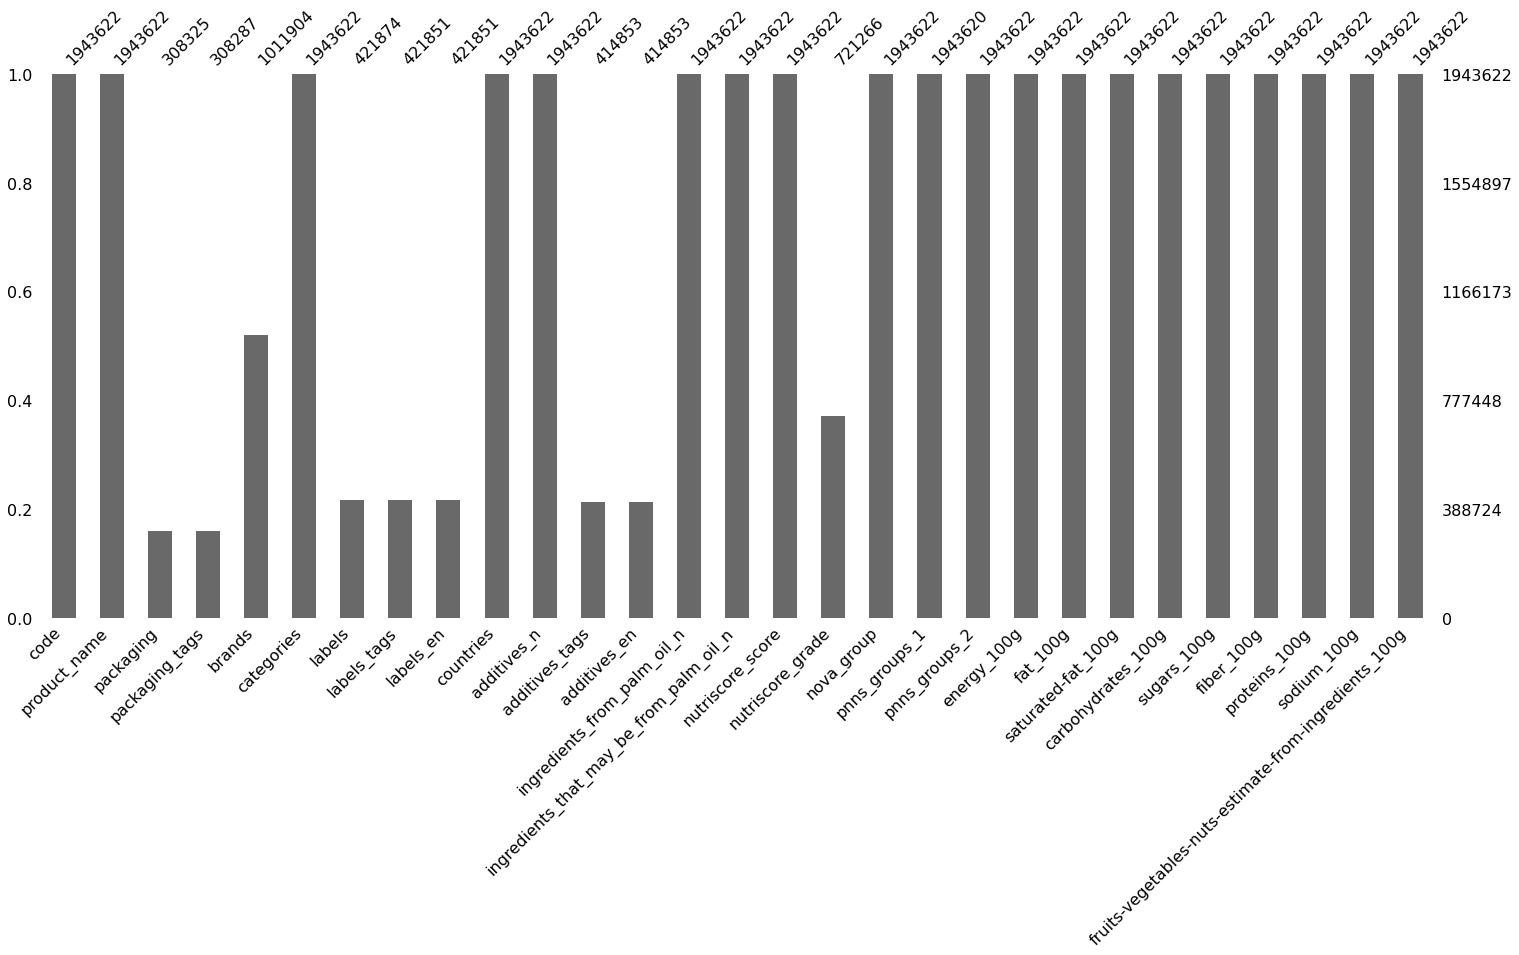

In [178]:
msno.bar(data)

In [179]:
data.head()

,code,product_name,packaging,packaging_tags,brands,categories,labels,labels_tags,labels_en,countries,...,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,NaN,NaN,endives,unknown,NaN,NaN,NaN,France,...,unknown,1088.0,7.0,1.70,17.4,3.57,2.2,6.1,0.232,0.0
1,00000000000003429145,L.casei,NaN,NaN,NaN,unknown,NaN,NaN,NaN,Espagne,...,unknown,1088.0,1.4,0.90,9.8,9.80,2.2,2.7,0.040,0.0
2,0000000000017,Vitória crackers,NaN,NaN,NaN,unknown,NaN,NaN,NaN,France,...,unknown,1569.0,7.0,3.08,70.1,15.00,2.2,7.8,0.560,0.0
3,0000000000031,Cacao,NaN,NaN,NaN,unknown,NaN,NaN,NaN,France,...,unknown,1088.0,7.0,1.70,17.4,3.57,2.2,6.1,0.232,0.0
4,000000000003327986,Filets de poulet panés,NaN,NaN,NaN,unknown,NaN,NaN,NaN,Espagne,...,unknown,685.8,1.9,1.00,17.4,3.57,2.2,15.3,0.440,0.0


Avant de commencer notre analyse Exploratoire, nous voulons examiner de plus près la variable "Energy_100g".

Nous savons que l'énergie qu'un produit peut être principalement calculée à travers sa quantité de glucides, de lipides et de protéines. Nous savons également ce qui suit : 

> 1 g de lipides contient environ 9.315 kcal Kcal d'énergie

> 1 g de glucides et de protéines contiennent tous deux environ 4.06 kcal d'énergie.

En raison du processus de saisie compliqué dans l'application OpenFoodFacts, certains utilisateurs saisissent des valeurs erronées. L'énergie est également souvent donnée en kJ et kcal, de sorte que les utilisateurs peuvent être encore plus confus. 

En calculant l'énergie sur la base des caractéristiques des graisses, des glucides et des protéines et en la comparant à la valeur d'énergie donnée, nous pouvons détecter si certaines entrées peuvent être erronées et pourraient même probablement les corriger dans certains cas.


# 1/ Reconstruisons le calcul de l'énergie 

In [180]:
data["reconstructed_energy_100g"] = data["fat_100g"] * 4.06 + data["carbohydrates_100g"] * 9.315 + data["proteins_100g"] * 9.315
data.head()

,code,product_name,packaging,packaging_tags,brands,categories,labels,labels_tags,labels_en,countries,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,reconstructed_energy_100g
0,00000000000000225,jeunes pousses,NaN,NaN,endives,unknown,NaN,NaN,NaN,France,...,1088.0,7.0,1.70,17.4,3.57,2.2,6.1,0.232,0.0,247.3225
1,00000000000003429145,L.casei,NaN,NaN,NaN,unknown,NaN,NaN,NaN,Espagne,...,1088.0,1.4,0.90,9.8,9.80,2.2,2.7,0.040,0.0,122.1215
2,0000000000017,Vitória crackers,NaN,NaN,NaN,unknown,NaN,NaN,NaN,France,...,1569.0,7.0,3.08,70.1,15.00,2.2,7.8,0.560,0.0,754.0585
3,0000000000031,Cacao,NaN,NaN,NaN,unknown,NaN,NaN,NaN,France,...,1088.0,7.0,1.70,17.4,3.57,2.2,6.1,0.232,0.0,247.3225
4,000000000003327986,Filets de poulet panés,NaN,NaN,NaN,unknown,NaN,NaN,NaN,Espagne,...,685.8,1.9,1.00,17.4,3.57,2.2,15.3,0.440,0.0,312.3145


Text(0, 0.5, 'reconstructed_energy_100g (Kcal)')

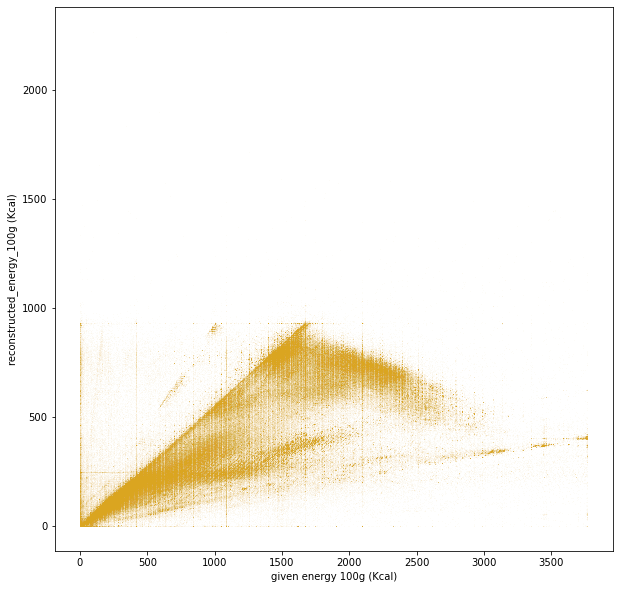

In [190]:
plt.figure(figsize = (10,10))
plt.scatter(data["energy_100g"], data["reconstructed_energy_100g"],s=0.0001, c= "goldenrod")
plt.xlabel("given energy 100g (Kcal)")
plt.ylabel("reconstructed_energy_100g (Kcal)")

Nous pouvons voir que les deux quantités d'énergie sont très bien corrélées. 
il existe tout de même des informations non cohérentes. 

Il existe certains produits avec une quantité d'énergie donnée de 0 kJ alors que l'énergie reconstruite est bien plus élevée. 

Cela signifie qu'il existe des valeurs de lipides, de glucides et de protéines supérieures à 0 g, et que la quantité d'énergie donnée dans ce cas est probablement erronée. 

D'autre part, il existe également des quantités d'énergie reconstruite faibles, tandis que la quantité d'énergie donnée est plus élevée. Dans ces cas, les valeurs des lipides, des glucides et des protéines dans nos données doivent être plus faibles.

En raison de ces résultats, il serait utile que nous prenions également en compte l'énergie reconstruite pour notre clustering :

Outre les erreurs que nous avons détectées grâce à notre énergie reconstruite, nous pouvons également détecter facilement une autre erreur : nos caractéristiques en matières grasses, glucides et protéines sont données sur la base de 100 g. Donc, si la somme de ces caractéristiques est supérieure à 100, nous saurons également qu'il y a quelque chose qui ne va pas avec nos données.

Voyons donc si nous pouvons trouver l'une de ces erreurs : 

In [191]:
data["g_sum"] = data.fat_100g + data.carbohydrates_100g + data.proteins_100g
data["exceeded"] = np.where(data.g_sum.values > 100, 1, 0)

In [192]:
data[data["exceeded"] == 1].head()

,code,product_name,packaging,packaging_tags,brands,categories,labels,labels_tags,labels_en,countries,...,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,reconstructed_energy_100g,g_sum,exceeded
127,0000000016513,Organic Sunflower Oil,NaN,NaN,Napa Valley Naturals,unknown,Organic,en:organic,Organic,Etats-Unis,...,7.14,17.4,3.57,2.2,6.10,0.232000,0.0,624.90250,123.50,1
132,0000000016933,Organic Golden Flax Seeds,NaN,NaN,Unfi,unknown,Organic,en:organic,Organic,Etats-Unis,...,4.76,38.1,3.57,38.1,19.05,0.038608,0.0,706.36385,100.01,1
159,0000000018562,"Sweeteners, Demerara Turbinado Sugar",NaN,NaN,"Wholesome, Wholesome Sweeteners",unknown,NaN,NaN,NaN,Etats-Unis,...,1.70,100.0,100.00,2.2,6.10,0.232000,0.0,1016.74150,113.10,1
202,0000000032384,Organic Couscous,NaN,NaN,Unfi,unknown,Organic,en:organic,Organic,Etats-Unis,...,1.70,80.0,3.57,4.4,13.33,0.011176,0.0,897.78895,100.33,1
208,0000000033268,"Sweeteners, Organic Fair Trade Sugar",NaN,NaN,"Wholesome, Wholesome Sweeteners",unknown,Organic,en:organic,Organic,Etats-Unis,...,1.70,100.0,100.00,2.2,6.10,0.232000,0.0,1016.74150,113.10,1


In [197]:
data.exceeded.value_counts() 

0    1936182
Name: exceeded, dtype: int64

In [194]:
data.tail(50)

,code,product_name,packaging,packaging_tags,brands,categories,labels,labels_tags,labels_en,countries,...,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,reconstructed_energy_100g,g_sum,exceeded
2035005,9999926741689,Vitaquell extra,NaN,NaN,NaN,unknown,"Organic, en:de-oko-013","en:organic,en:eu-organic,en:de-oko-013","Organic,EU Organic,DE-ÖKO-013",Suisse,...,1.70,17.40,3.570,2.2,6.10,0.232,0.0,247.32250,30.50,0
2035006,99999300000,Rooibos nature Bio,NaN,NaN,Nature Bio,unknown,Bio,en:organic,Organic,France,...,1.70,17.40,3.570,2.2,6.10,0.232,0.0,247.32250,30.50,0
2035007,9999933090183,Pasta lassar,NaN,NaN,NaN,unknown,NaN,NaN,NaN,Chili,...,1.70,17.40,3.570,2.2,6.10,0.232,0.0,247.32250,30.50,0
2035008,9999990000514,Miel de Garriguella,NaN,NaN,NaN,unknown,NaN,NaN,NaN,Espagne,...,1.70,17.40,3.570,2.2,6.10,0.232,0.0,247.32250,30.50,0
2035009,9999990001610,Son de blé Bio,NaN,NaN,NaN,unknown,Bio,en:organic,Organic,France,...,1.70,17.40,3.570,2.2,6.10,0.232,0.0,247.32250,30.50,0
2035010,9999990002785,Bière fermière miel de forêt,NaN,NaN,NaN,unknown,NaN,NaN,NaN,France,...,1.70,17.40,3.570,2.2,6.10,0.232,0.0,247.32250,30.50,0
2035011,9999990003508,Confiture,NaN,NaN,NaN,unknown,NaN,NaN,NaN,France,...,0.02,55.53,55.520,2.2,0.34,0.000,0.0,520.99745,56.01,0
2035012,9999990004284,Rillettes,NaN,NaN,NaN,unknown,NaN,NaN,NaN,France,...,1.70,17.40,3.570,2.2,6.10,0.000,0.0,247.32250,30.50,0
2035013,9999990004529,Miel d'acacia ruchers de badon,NaN,NaN,NaN,"Produits à tartiner, Petit-déjeuners, Produits...",NaN,NaN,NaN,France,...,0.18,63.64,53.000,1.0,0.82,0.020,0.0,602.47490,64.96,0
2035014,9999990005052,Confiture de pêche,NaN,NaN,NaN,fr:Confiture de pêche,NaN,NaN,NaN,France,...,0.18,63.64,53.000,1.0,0.82,0.020,0.0,602.47490,64.96,0


Il y a vraiment des produits enregistrés avec cette erreur. Comme nous pouvons le voir ci-dessus, il y a 7440 produits avec cette erreur.

In [195]:
# Suppression des produits avec somme nutritionnelle suppérieure à 100 g pour une portion de 100g
data=data[data.exceeded != 1]

In [198]:
rows_drop_g_sum_sup100= data.shape[0]
cols_drop_g_sum_sup100 = data.shape[1]
print('Nombre de lignes restants = ',rows_drop_g_sum_sup100)
print('Nombre de colonnes restants = ',cols_drop_g_sum_sup100)

Nombre de lignes restants =  1936182
Nombre de colonnes restants =  32


In [199]:
# suppression des colonnes "fruits-vegetables-nuts-estimate-from-ingredients_100g" et "energy_100g"
col_drop = ['fruits-vegetables-nuts-estimate-from-ingredients_100g', 'energy_100g'] 
data.drop(col_drop, axis=1, inplace=True)

In [200]:
rows_drop_fruits_vegetables_energy_100g= data.shape[0]
cols_drop_fruits_vegetables_energy_100g = data.shape[1]
print('Nombre de lignes restants = ',rows_drop_fruits_vegetables_energy_100g)
print('Nombre de colonnes restants = ',cols_drop_fruits_vegetables_energy_100g)

Nombre de lignes restants =  1936182
Nombre de colonnes restants =  30


### Etapes de réduction des dimensions de la Dataset 
au total, nous avons effectuer 10 étapes de réduction des dimensions de la dataset en lignes (produits) 

In [207]:
reduction_rows = pd.DataFrame({'Nombres_de_lignes': [Nbr_lignes_initial,rows_no_need_columns,rows_Prct_85,rows_redundant_columns, rows_outliers, rows_duplicates,rows_drop_energy_higher_900_lower_0,rows_drop_no_name_products,rows_drop_pastries_group,rows_drop_g_sum_sup100,rows_drop_fruits_vegetables_energy_100g],'Evolution': ['Initial','Prct_85','no_need_columns','redundant_colmns', 'outliers', 'duplicated_rows', 'Energy_rows_drp ', 'No_name_products', 'pastries_group','g_sum','fruits_vegetables_energy_100g']},index = [0, 1, 2, 3, 4, 5,6,7,8,9,10])
reduction_columns = pd.DataFrame({'Nombres_de_colonnes': [Nbr_colonnes_initial,cols_no_need_columns,cols_Prct_85,cols_redundant_columns, cols_outliers,cols_duplicates, cols_drop_energy_higher_900_lower_0,cols_drop_no_name_products,cols_drop_pastries_group,cols_drop_g_sum_sup100,cols_drop_fruits_vegetables_energy_100g],'Evolution': ['Initial','Prct_85','no_need_cols','redundant', 'outliers', 'duplicated_rows', 'Energy_rows_drp ', 'No_name_products', 'pastries_group','g_sum','fruits_vegetables_energy_100g']},index = [0, 1, 2, 3, 4, 5,6,7,8,9,10])

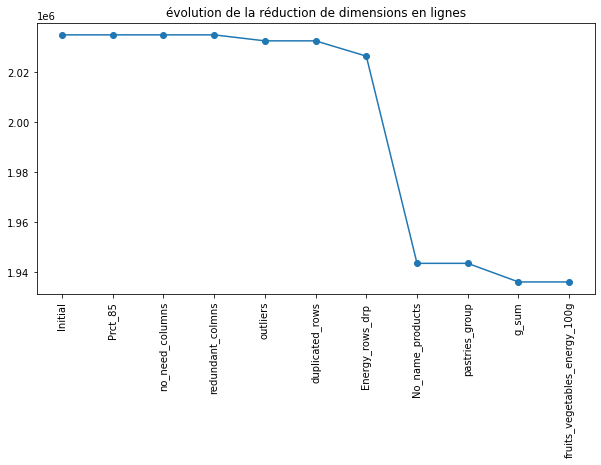

In [208]:
# Affichage de l'évolution des dimensions en lignes 
figure = plt.figure(figsize=(10,5))
plt.title('évolution de la réduction de dimensions en lignes')
plt.xticks(rotation=90)
plt.plot(reduction_rows['Evolution'].values,reduction_rows['Nombres_de_lignes'].values, marker='o')

Au total, nous avons effectuer 10 étapes de réduction des dimensions de la dataset en colonnes (produits)

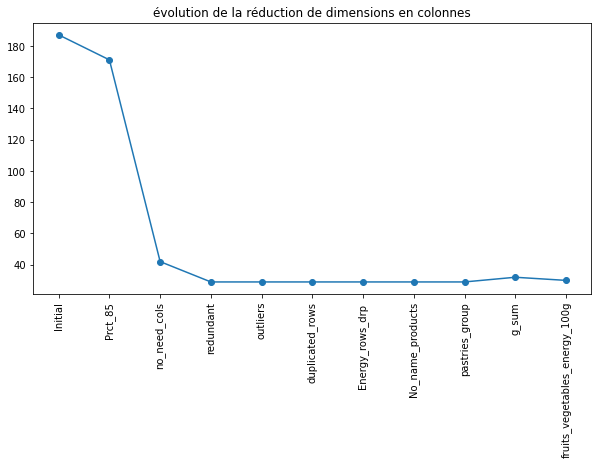

In [209]:
# Affichage de l'évolution des dimensions en colonnes 
figure = plt.figure(figsize=(10,5))
plt.title('évolution de la réduction de dimensions en colonnes')
plt.xticks(rotation=90)
plt.plot(reduction_columns['Evolution'].values,reduction_columns['Nombres_de_colonnes'].values, marker='o')

In [215]:
print('Nombre de lignes final = ',data.shape[0])
print('Nombre de colonnes final = ',data.shape[1])

Nombre de lignes final =  1936182
Nombre de colonnes final =  28


In [212]:
# suppression des colonnes "g_sum" et "exceeded"
col_drop = ['g_sum', 'exceeded'] 
data.drop(col_drop, axis=1, inplace=True)

In [213]:
data.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,reconstructed_energy_100g
count,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06,1.936182e+06
mean,1.369686e+00,7.513240e-03,2.806554e-02,9.472639e+00,3.717351e+00,1.238296e+01,4.364870e+00,2.605358e+01,1.146782e+01,2.177086e+00,8.183514e+00,4.749439e-01,3.691934e+02
std,1.879703e+00,8.750537e-02,1.930804e-01,5.728145e+00,7.126577e-01,1.632983e+01,7.054503e+00,2.601197e+01,1.802924e+01,2.726575e+00,9.114463e+00,1.829233e+00,2.508178e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,1.100000e+00,1.900000e-01,4.400000e+00,8.000000e-01,1.000000e+00,1.800000e+00,4.000000e-02,1.883274e+02
50%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,7.000000e+00,1.700000e+00,1.740000e+01,3.570000e+00,2.200000e+00,6.100000e+00,2.320000e-01,2.602455e+02
75%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,1.785714e+01,5.300000e+00,4.776119e+01,1.230000e+01,2.200000e+00,1.090000e+01,4.440000e-01,6.024749e+02
max,4.100000e+01,3.000000e+00,6.000000e+00,4.000000e+01,4.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,9.315000e+02


In [214]:
# Sauvegarde de la base de données nettoyée
data.to_csv("en.openfoodfacts.org.products_clean.csv", index=False)